<a href="https://colab.research.google.com/github/mauriciodev/spatialgeodesy/blob/main/notebooks/basic_gnss_adjustment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Basic GNSS adjustment

Calculate the SPJA coordinates given SPFR, EESC and SJRP coordinates and their GNSS baselines.

Theoretical explanation: https://www.youtube.com/watch?v=_9sWpabRCz4

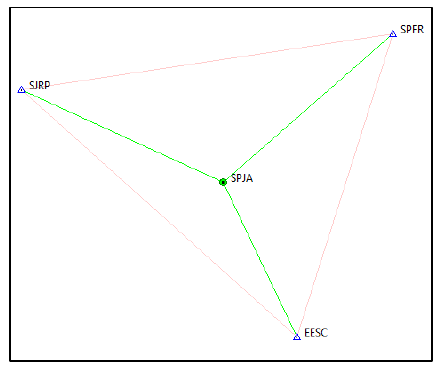

In [ ]:
stationsData="""Station,X (m),Sigma X (m),Y (m),Sigma Y (m),Z (m),Sigma Z (m)
EESC,3967006.963,0.001,-4390247.349,0.003,-2375229.945,0.002
SJRP,3885706.901,0.002,-4527123.948,0.001,-2249400.141,0.003
SPFR,4046871.081,0.003,-4398880.413,0.001,-2221086.61,0.002"""

baselinesData="""Base lines,DX (m),DY (m),DZ (m),sigma DX (m),sigma DY (m),sigma DZ (m)
SJRP->SPJA, 72099.729, 87054.252, -47099.698, 0.031, 0.036, 0.023
SPFR->SPJA, -89064.46, -41189.29, -75413.234, 0.034, 0.034, 0.022
EESC->SPJA, -9200.333, -49822.35, 78730.108, 0.028, 0.031, 0.02"""

# Libraries

In [ ]:
#Imported libraries
import os
import numpy as np
from numpy import *
import pandas as pd
import matplotlib.pyplot as plt
from io import StringIO ## for Python 3

np.set_printoptions(edgeitems=30, linewidth=150, formatter={'float': lambda x: "{0:0.5f}".format(x)})

In [ ]:
def numpy2latex(a):
    print('\\begin{gather}')
    lines = str(a).replace('[', '').replace(']', '').splitlines()
    rv = [r'\begin{bmatrix}']
    rv += ['  ' + ' & '.join(l.split()) + r'\\' for l in lines]
    rv +=  [r'\end{bmatrix}']
    print('\n'.join(rv))
    print('\\end{gather}')

# Input data

In [ ]:
stationsDF=pd.read_csv(StringIO(stationsData)).sort_values(by="Station")
stationsDF

In [ ]:
baselinesDF=pd.read_csv(StringIO(baselinesData)).sort_values(by="Base lines")
baselinesDF

# Reorganizing observations

In [ ]:
observations=baselinesDF[["DX (m)",	"DY (m)",	"DZ (m)"]].to_numpy() #Measures for each station XYZ
observations=observations.flatten() #making a single column so it's: [x,y,z,x,y,z,x,y,z]
observations

In [ ]:
obsSigma=baselinesDF[["sigma DX (m)",	"sigma DY (m)",	"sigma DZ (m)"]].to_numpy() #std Deviation for each
obsSigma=obsSigma.flatten()
obsSigma

In [ ]:
baseCoords=stationsDF[["X (m)",	"Y (m)",	"Z (m)"]].to_numpy() #Coordinates for each station
baseCoords=baseCoords.flatten()
baseCoords

In [ ]:
baseSigma=stationsDF[["Sigma X (m)",	"Sigma Y (m)",	"Sigma Z (m)"]].to_numpy() #Coordinates for each station
baseSigma=baseSigma.flatten()
baseSigma

# Least squares network adjustment

## Absolute injunction
Base coordinates are added.

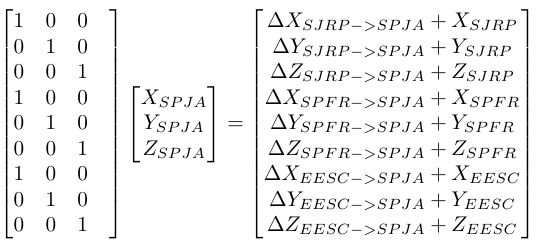

In [ ]:
A=np.tile(np.identity(3),(3,1)) #concatenating identities to make A
A

In [ ]:
#Observations
L=baseCoords+observations
L

In [ ]:
#variance propagation
sigmas=np.sqrt(obsSigma**2+baseSigma*2)
#sigmas=obsSigma
#building the diagonal matrix
P=np.linalg.inv(np.diag(sigmas**2))
P

In [ ]:
#least squares
AtPA_inv=np.linalg.inv(A.T @ P @ A)
X_fit=AtPA_inv @ A.T @ P @ L
#least squares using numpy
#X_fit=np.linalg.lstsq(A, L,rcond=None)[0]
X_fit 

Expected (from RBMC): \\
X: 3.957.806,6961 m \\
Y: -4.440.069,7850 m \\
Z: -2.296.499,8742 m \\

## Relative injunction
Coordinates of the bases are treated as observations too.

## Design Matrix

In [ ]:
nstations=3
#concatenating identities to make A, same as above.
A=np.tile(np.identity(3),(nstations,1)) 
#adding the difference to the base coordinates
A=np.concatenate((A,np.identity(9)*-1),axis=1)
#adding the coordinates observations
A2=np.tile(np.zeros((3,3)),(nstations,1)) 
A2=np.concatenate((A2,np.identity(9)),axis=1)
A2
A=np.concatenate((A,A2), axis=0)
A

##Observations


In [ ]:
Lb=np.concatenate((observations,baseCoords))
numpy2latex(Lb)

## variance propagation


In [ ]:
sigmas=np.concatenate((obsSigma,baseSigma))
#sigmas=obsSigma
#building the diagonal matrix
MVC_Lb=np.diag(sigmas**2)
print(MVC_Lb)

 ## Weights
 Based on the variance covariance matrix

In [ ]:
sigma0=1
P=sigma0**2*np.linalg.inv(MVC_Lb)
print(P)

## Least squares fitting


In [ ]:
AtPA_inv=np.linalg.inv(A.T @ P @ A)
X_fit=AtPA_inv @ A.T @ P @ Lb
X_fit 

In [ ]:
print("Coordinates:", X_fit[:3])

Expected (from RBMC): \\
X: 3.957.806,6961 m \\
Y: -4.440.069,7850 m \\
Z: -2.296.499,8742 m \\

In [ ]:
dof=len(Lb)-len(X_fit)
print("Degrees of freedom:",dof)

In [ ]:
V=Lb-A @ X_fit
sigma2=V.T @ P @ V 
print("Variance:",sigma2)

MVC_Xa=sigma2*AtPA_inv
print("Variance Covariance Matrix for the adjusted values")
print(MVC_Xa)

print("Standard deviation:",np.sqrt(MVC_Xa.diagonal()))

MVC_La=A @ MVC_Xa @ A.T
print("Variance Covariance Matrix for the adjusted observations")
print(MVC_La)

MVC_v=MVC_Lb+MVC_La
print("Variance Covariance Matrix for the residuals")
print(MVC_v)

## Chi square test

In [ ]:
from scipy.stats import chi2

In [ ]:
prob = 0.975
critical = chi2.ppf(prob, dof)
print('probability=%.3f, critical=%.3f' % (prob, critical))

In [ ]:
sigma2

In [ ]:
T= sigma2/sigma0**2 *dof
T

In [ ]:
if T<critical:
  print("Passed.")
else:
  print("Reproved.")

# Latex matrices

In [ ]:
#np.set_printoptions(edgeitems=30, linewidth=150, formatter={'float': lambda x: "{0:0.2f}".format(x)})
numpy2latex(MVC_Lb*1000)

In [ ]:
numpy2latex(A @ X_fit) #La

In [ ]:
numpy2latex(X_fit) #Xa